In [30]:
from fastai import *
from fastai.text import *
from fastai.datasets import *
from pathlib import Path
import html
import fastai

In [31]:
# Check that the latest 1.0.0 build of PyTorch has been installed 
# alongside fastai
import torch
print("Cuda available" if torch.cuda.is_available() is True else "CPU")
print("PyTorch version: ", torch.__version__)

Cuda available
PyTorch version:  1.0.1.post2


In [32]:
#path = untar_data("http://files.fast.ai/data/examples/imdb_sample.tgz",dest=DATA_PATH)
path = Path('/home/dell/Code/fastai_examples/data/imdb_sample/')

In [33]:
df = pd.read_csv(path/'texts.csv')
df.head()

,label,text,is_valid
0,negative,Un-bleeping-believable! Meg Ryan doesn't even ...,False
1,positive,This is a extremely well-made film. The acting...,False
2,negative,Every once in a long while a movie will come a...,False
3,positive,Name just says it all. I watched this movie wi...,False
4,negative,This movie succeeds at being one of the most u...,False


In [34]:
dataProcess = False
modelTrain = True

In [35]:
if dataProcess:
    # Language model data
    data_lm = TextLMDataBunch.from_csv(path, 'texts.csv')
    # Classifier model data
    data_clas = TextClasDataBunch.from_csv(path, 'texts.csv', vocab=data_lm.train_ds.vocab, bs=64)
    data_lm.save('data_lm_export.pkl')
    data_clas.save('data_clas_export.pkl')
else:
    data_lm = load_data(path, fname='data_lm_export.pkl')
    data_clas = load_data(path, fname='data_clas_export.pkl', bs=16)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


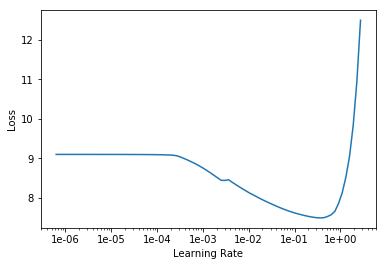

In [36]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.5, pretrained=False)
learn.lr_find()
learn.recorder.plot()

In [37]:
preTrainedWt103Path = Path('/home/dell/Code/fastai_examples/data/models/wt103')
# ! wget -nH -r -np -P {preTrainedWt103Path} http://files.fast.ai/models/wt103/ 

In [ ]:
if modelTrain:
    learn.load_pretrained(wgts_fname = preTrainedWt103Path/'fwd_wt103.h5', itos_fname = preTrainedWt103Path/'itos_wt103.pkl', strict=False )
    #learn.load_encoder(name=preTrainedWt103Path/'fwd_wt103_enc.h5')
    learn.fit_one_cycle(1, 1e-2)
    pathModel = learn.save(path/"trained_model")
else:
    learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.5, pretrained=False)
    learn.load(path/"trained_model")

epoch,train_loss,valid_loss,accuracy,time


We can we visualize  text classifier as three different part, 1 and 2 is backbone and 3 is head.

1- Embedding layer (Convert integer of words to meaningful vectors)
2- 3 Layer LSTM network (Learned from wikitext and language-model)
3- Finallinear layer  network for Prediction

In [ ]:
learn.model

In [ ]:
learn.predict("This is a review about", n_words=50)

In [ ]:
x_inp = ["i like apples",
         "i want to buy some apples",
         "where is your cell phone",
        "buy me some apples"]

In [ ]:
x_inp2 = ["king",
         "woman",
          "man",
         "queen"
         ]

In [ ]:
inputs = x_inp2

In [ ]:
import multiprocessing
n_cpu = multiprocessing.cpu_count()

In [ ]:
tok = Tokenizer().process_all(partition_by_cores(inputs,n_cpu-1))
tok

In [ ]:
import re 

#to calculate a accurate similarity special tokens will be excluded

filteredTokens = []
for tokenizedWord in tok:
    filteredToken = [token for token in tokenizedWord if not re.search('xx',token)]
    filteredTokens.append(filteredToken)
filteredTokens

In [ ]:
X = [[data_lm.vocab.stoi[o1] for o1 in o ] for o in filteredTokens]; X 

In [ ]:
#to calculate a accurate similarity non vocab words will be excluded
X = [element for element in X if element[2] != 0 ]; X

In [ ]:
m = learn.model

In [ ]:
#inputs = []
embeddings = []    
for sentence in X:
    #resizeLength = len(x_inp4)
    #to calculate a accurate similarity special chars at the begining and ending will be excluded
    sentenceTrimmed= sentence[2:-2]
    resizeLength = len(sentenceTrimmed)
    inputSentence = tensor(sentenceTrimmed).resize_(resizeLength,1)
    # sentence encoding 400 dims. -1 is the last element that's supposed to have the final encoded state
    tmpEmbded = m[0](inputSentence.cuda())
    embeddings.append(tmpEmbded[0][2][0][-1])

In [ ]:
def cos_sim(v1,v2):
    return F.cosine_similarity(v1.unsqueeze(0),v2.unsqueeze(0))#.mean()

In [ ]:
inputs

In [ ]:
i=0
for embedding1 in embeddings:
    j=0
    for embedding2 in embeddings:
        #corr = data_lm.vocab.itos[X[i][2]] + " with " + data_lm.vocab.itos[X[j][2]]
        corr = inputs[i] + " with " + inputs[j]
        print(corr)
        print(cos_sim(embedding1,embedding2).item())
        j+=1
    i+=1